In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import kde
from scipy.integrate import odeint
import scipy.stats as stats
import torch
from torch.autograd import Function
import torch.nn as nn
import pyro
from pyro.nn import PyroSample
from pyro.nn import PyroModule
import pyro.distributions as dist
from pyro.infer.autoguide import AutoMultivariateNormal
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.optim import AdagradRMSProp
from pyro.infer.mcmc import NUTS
from pyro.infer.mcmc.api import MCMC


# Student-t noise inference example using the Goodwin model

In this notebook we will show the effects of having a wrong noise assumption. Our aim in this notebook is to demonstrate that under a wrong modelling assumption black-box variational inference would still produce similar results in comparison to NUTS.

In order demonstrate the wrong modelling assumption we will first generate experiemental data by adding Student's-t noise. The Student-t distribution has fatter tails than the normal and thus using a Normal likelihood (the wrong model) would lead to a wrong estimation of the noise scale. Later we will show that using a Student-t likelihood both VI and NUTS would be able to correctly estimate the noise scale.  

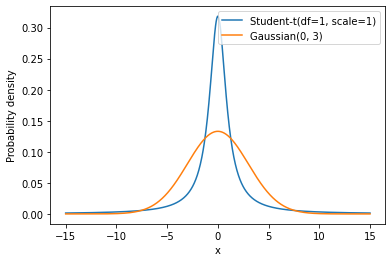

In [8]:
x = np.linspace(-15, 15, 1000)
y_t = stats.t.pdf(x, 1, loc=0, scale=1)
y_norm = stats.norm.pdf(x, 0, 3)
plt.plot(x, y_t, label ='Student-t(df=1, scale=1)')
plt.plot(x, y_norm, label ='Gaussian(0, 3)')
plt.xlabel('x')
plt.ylabel('Probability density')
plt.legend()
plt.show()

## Define the Goodwin model solver class and sensitivity functions



In [0]:
class GoodwinModel(object):

    def __init__(self, times, y0=None):

        if y0 is None:
            self._y0 = np.array([0,0,0], dtype=float)
        else:
            self._y0 = np.array(y0, dtype=float)
        self._n_states = 3
        self._n_params = 5
        self._times = times
        self._T = len(times)
            
    def solve(self, parameters):
        return self._solve(parameters, False)

    def solve_with_sensitivities(self, parameters):
        return self._solve(parameters, True)

    def _solve(self, parameters, sensitivities):
        a1, a2, alpha, k1, k2 = [float(x) for x in parameters]       

        def r(y, t, p):
            
            X1, X2, X3=y
            dX1_dt = (a1/( 1 + (a2*(X3**10)) ) ) - (alpha*X1);
            dX2_dt = (k1*X1) - (alpha*X2);
            dX3_dt = (k2*X2) - (alpha*X3);
            
            return dX1_dt,dX2_dt,dX3_dt

        if sensitivities:
            def jac_x(y):
                X1, X2, X3 = y
                ret = np.empty((self._n_states, self._n_states))
                ret[0, 0] = -alpha
                ret[0, 1] = 0
                ret[0, 2] = -(a1*a2*10*(X3**9))/( (1 + a2*(X3**10))**2 )
                
                ret[1, 0] = k1
                ret[1, 1] = -alpha
                ret[1, 2] = 0
                
                ret[2, 0] = 0
                ret[2, 1] = k2
                ret[2, 2] = -alpha
                return ret

            def jac_p(y):
                X1, X2, X3 = y
                ret = np.empty((self._n_states, self._n_params))
                ret[0, 0] = 1/(1+a2*(X3**10))
                ret[0, 1] = -(a1*(X3**10))/( (1 + a2*(X3**10))**2 )
                ret[0, 2] = -X1
                ret[0, 3] = 0
                ret[0, 4] = 0
                
                ret[1, 0] = 0
                ret[1, 1] = 0
                ret[1, 2] = -X2
                ret[1, 3] = X1
                ret[1, 4] = 0
                
                ret[2, 0] = 0
                ret[2, 1] = 0
                ret[2, 2] = -X3
                ret[2, 3] = 0
                ret[2, 4] = X2               
                return ret

            def rhs(y_and_dydp, t, p):
                y = y_and_dydp[0:self._n_states]
                dydp = y_and_dydp[self._n_states:].reshape((self._n_states, self._n_params))

                dydt = r(y, t, p)
                d_dydp_dt = np.matmul(jac_x(y), dydp) + jac_p(y)

                return np.concatenate((dydt, d_dydp_dt.reshape(-1)))

            y0 = np.zeros(18)
            y0[0:self._n_states] = self._y0
            result = odeint(rhs, y0, self._times, (parameters,), rtol=1e-5, atol=1e-6)
            x = result[:, 0:self._n_states]
            dx_dp = result[:, self._n_states:].reshape((self._T, self._n_states, self._n_params))
            return x, dx_dp, self._T, self._n_states, self._n_params
        else:
            x = odeint(r, self._y0, self._times, (parameters,), rtol=1e-5, atol=1e-6)
            return x


## Simulated (fake) data with heavy-tail noise following Student's-t distribution

We generated data from the above model with parameters $a_1=1.97$, $a_2=0.15$, $\alpha=0.53$, $k_1=0.46$ and $k_2=1.49$ and initial conditions $(x_1(t_0),x_2(t_0),x_3(t_0))$ set to zero. The noise scale is set to 0.1.



Text(0, 0.5, 'Concentration')

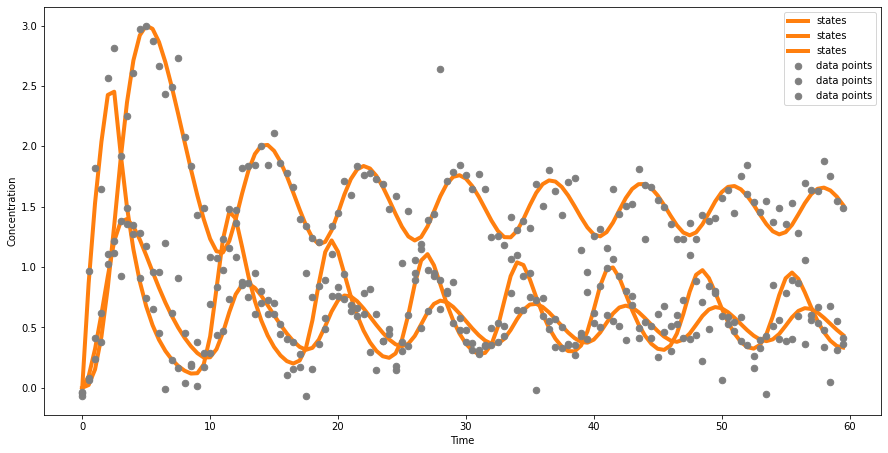

In [0]:
times = np.arange(0,60, 0.5)
gw_ode_model = GoodwinModel(times);
sigma=0.1
real_params = [1.97,0.15,0.53,0.46,1.49]
sol=gw_ode_model.solve(real_params)
np.random.seed(121) 
Y=sol + stats.t.rvs(df=2, loc=0, scale=sigma, size=sol.shape)
plt.figure(figsize=(15, 7.5))
plt.plot(times, sol, '-', color='#ff7f0e', lw=4, label='states')
plt.plot(times, Y, 'o', color='#7f7f7f', ms=6.5, label='data points')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Concentration')

## Custom ODE op

We use here the same custom-op that we have used before.

In [0]:
class ODEop(Function):  
    @staticmethod
    def forward(ctx, params): 
        numpy_params = params.detach().numpy()
        
        states, Jac_p, T, k, d = gw_ode_model.solve_with_sensitivities(numpy_params)
        ctx.T, ctx.k, ctx.d = T, k, d
        ctx.save_for_backward(torch.as_tensor(Jac_p, dtype=params.dtype))
        return torch.as_tensor(states, dtype=params.dtype)

    @staticmethod
    def backward(ctx, grad_output):
        T = ctx.T
        d = ctx.d
        k = ctx.k
        bJac = ctx.saved_tensors[0]
        numpy_Jac = bJac.detach().numpy().reshape((k*T,d))
        g = grad_output.detach().numpy().reshape(k*T)
        vjp = g.T.dot(numpy_Jac)          
        return torch.from_numpy(vjp)

## The probabilistic (generative) model with WRONG noise assumption

We consider the initial values to be known and placed the same a $\operatorname{Gamma}(2,1)$ prior on all the five ODE parameters and a half-Normal, $\mathcal{H}(1)$, prior on the noise standard deviation parameter. 

The likelihood follows the wrong noise assumption: $p(\boldsymbol{y}|\boldsymbol{x}(\boldsymbol{\theta}))=\underset{t}{\prod}\mathcal{N}(\boldsymbol{x}(t),\sigma_x^2\mathbb{I})$.



In [0]:
y_torch = torch.tensor(Y,dtype=torch.float)

In [0]:
class GoodwinGenModelNorm(PyroModule):
    def __init__(self):        
        super(GoodwinGenModelNorm, self).__init__()
        self.ode_params = PyroSample(dist.Gamma(
            torch.tensor([2.0,2.0,2.0,2.0,2.0]),1.0).to_event(1) )      
        
    def forward(self, data):         
        scale = pyro.sample("scale", dist.HalfNormal(1.0))
        states = ODEop.apply(self.ode_params)
        with pyro.plate("map", len(data)):

            pyro.sample("obs",
                        dist.Normal(states, scale).to_event(1),
                        obs=data)
            return states

## Carry out variotional inference with the full-rank Gaussian approximation



In [0]:
pyro.set_rng_seed(121)
pyro.clear_param_store()
model = GoodwinGenModelNorm()
guide = AutoMultivariateNormal(model)
optim = AdagradRMSProp({"eta": 0.1})
svi = SVI(model, guide, optim, loss=Trace_ELBO())
def train():
    loss_trace = []
    for j in range(20000):
        # calculate the loss and take a gradient step
        loss = svi.step(y_torch)
        loss_trace.append(loss)
        if j % 500 == 0:
            print("[iteration %04d] loss: %.4f" % (j + 1, np.mean(loss_trace[-100:])))
    return loss_trace

In [0]:
%%time
loss_graph = train()
predictive = Predictive(model, guide=guide, num_samples=1000,
                        return_sites=("ode_params", "scale", "obs", "_RETURN"))
vb_ppc_samples = predictive(y_torch)
vb_params_norm=np.concatenate((vb_ppc_samples['ode_params'].detach().numpy().reshape((1000,5))
                          ,vb_ppc_samples['scale'].detach().numpy()),axis=1)

[iteration 0001] loss: 525.8024
[iteration 0501] loss: 86.4803
[iteration 1001] loss: -7.3590
[iteration 1501] loss: -32.3856
[iteration 2001] loss: -42.2465
[iteration 2501] loss: -45.0729
[iteration 3001] loss: -47.2682
[iteration 3501] loss: -46.4987
[iteration 4001] loss: -47.9373
[iteration 4501] loss: -47.6392
[iteration 5001] loss: -48.3605
[iteration 5501] loss: -48.0997
[iteration 6001] loss: -48.5106
[iteration 6501] loss: -48.4741
[iteration 7001] loss: -48.5932
[iteration 7501] loss: -48.6905
[iteration 8001] loss: -48.7204
[iteration 8501] loss: -49.5164
[iteration 9001] loss: -48.9474
[iteration 9501] loss: -48.8189
[iteration 10001] loss: -49.1190
[iteration 10501] loss: -49.0028
[iteration 11001] loss: -49.1418
[iteration 11501] loss: -49.1433
[iteration 12001] loss: -49.3123
[iteration 12501] loss: -48.9987
[iteration 13001] loss: -49.2126
[iteration 13501] loss: -49.3669
[iteration 14001] loss: -49.3863
[iteration 14501] loss: -49.3081
[iteration 15001] loss: -49.2163

## MCMC baseline

Next we apply the NUTS algorithm for inference. This acts as a baseline to compare the variational inference results against.

In [0]:
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=1000)
mcmc.run(y_torch)
hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}
mc_params_norm=np.concatenate((hmc_samples['ode_params'][::1,:].reshape((1000,5))
                          ,hmc_samples['scale'].reshape((-1,1))[::1,:]),axis=1)

Warmup:   0%|          | 0/2000 [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in matmul
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: overflow encountered in double_scalars
Sample: 100%|██████████| 2000/2000 [48:06,  1.44s/it, step size=3.60e-01, acc. prob=0.924]


### Compare the estimation result

Interestingly the noise scale $\sigma_x$ is estimated incorrectly in order to adjust for the fatter tails.

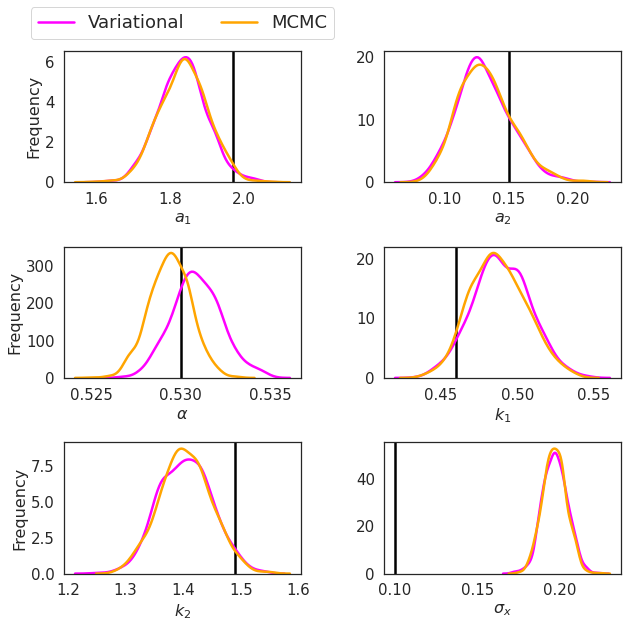

In [0]:
param_names = [r"$a_1$", r"$a_2$", r"$\alpha$", r"$k_1$", r"$k_2$", r"$\sigma_x$"]
sns.set_context("paper", font_scale=1)
sns.set(rc={"figure.figsize":(9,9),"font.size":16,"axes.titlesize":16,"axes.labelsize":16,
           "xtick.labelsize":15, "ytick.labelsize":15},style="white")
real_params.append(0.1)
for i, p in enumerate(param_names):
        
        # Add histogram subplot
        plt.subplot(3, 2, i+1)
        plt.axvline(real_params[i], linewidth=2.5, color='black')
        if i==0:
            sns.kdeplot(vb_params_norm[:, i], color='magenta', linewidth = 2.5, label='Variational')
            sns.kdeplot(mc_params_norm[:, i], color='orange', linewidth = 2.5,label='MCMC')
        else:
            sns.kdeplot(vb_params_norm[:, i], linewidth = 2.5, color='magenta')
            sns.kdeplot(mc_params_norm[:, i], linewidth = 2.5, color='orange')  

        if i%2==0:
            plt.ylabel('Frequency')
        plt.xlabel(param_names[i])        
        if i<1:
            plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower center', ncol=2,fontsize=18)
plt.subplots_adjust(hspace=0.7)
plt.tight_layout()

## Re-run the inferences now with correct noise assumption

In [0]:
class GoodwinGenModelST(PyroModule):
    def __init__(self):        
        super(GoodwinGenModelST, self).__init__()
        self.ode_params = PyroSample(dist.Gamma(
            torch.tensor([2.0,2.0,2.0,2.0,2.0]),1.0).to_event(1) )      
        
    def forward(self, data):         
        scale = pyro.sample("scale", dist.HalfNormal(1.0))
        states = ODEop.apply(self.ode_params)
        with pyro.plate("map", len(data)):

            pyro.sample("obs",
                        dist.StudentT(2, states, scale).to_event(1),
                        obs=data)
            return states

## First we run VI

In [0]:
pyro.set_rng_seed(121)
pyro.clear_param_store()
modelST = GoodwinGenModelST()
guide = AutoMultivariateNormal(modelST)
optim = AdagradRMSProp({"eta": 0.1})
svi_ST = SVI(modelST, guide, optim, loss=Trace_ELBO())
def train():
    loss_trace = []
    for j in range(30000):
        # calculate the loss and take a gradient step
        loss = svi_ST.step(y_torch)
        loss_trace.append(loss)
        if j % 500 == 0:
            print("[iteration %04d] loss: %.4f" % (j + 1, np.mean(loss_trace[-100:])))
    return loss_trace

In [0]:
%%time
loss_graph = train()
predictive = Predictive(modelST, guide=guide, num_samples=1000,
                        return_sites=("ode_params", "scale", "obs", "_RETURN"))
vb_ppc_samples_ST = predictive(y_torch)
vb_params_st=np.concatenate((vb_ppc_samples_ST['ode_params'].detach().numpy().reshape((1000,5))
                          ,vb_ppc_samples_ST['scale'].detach().numpy()),axis=1)

[iteration 0001] loss: 447.0030
[iteration 0501] loss: 162.2003
[iteration 1001] loss: 152.6227
[iteration 1501] loss: 139.4096
[iteration 2001] loss: 94.0256
[iteration 2501] loss: 37.0885
[iteration 3001] loss: -41.5049
[iteration 3501] loss: -75.5941
[iteration 4001] loss: -106.3085
[iteration 4501] loss: -114.1289
[iteration 5001] loss: -120.7180
[iteration 5501] loss: -122.4098
[iteration 6001] loss: -123.8165
[iteration 6501] loss: -124.7180
[iteration 7001] loss: -125.7952
[iteration 7501] loss: -125.8292
[iteration 8001] loss: -126.1953
[iteration 8501] loss: -127.6573
[iteration 9001] loss: -126.6637
[iteration 9501] loss: -126.3484
[iteration 10001] loss: -127.2061
[iteration 10501] loss: -127.2981
[iteration 11001] loss: -127.2370
[iteration 11501] loss: -127.5453
[iteration 12001] loss: -127.5861
[iteration 12501] loss: -127.0135
[iteration 13001] loss: -127.6339
[iteration 13501] loss: -127.9445
[iteration 14001] loss: -128.0275
[iteration 14501] loss: -127.8330
[iteration

## Now re-run NUTS

In [0]:
pyro.set_rng_seed(121)
pyro.clear_param_store()
modelST = GoodwinGenModelST()

In [0]:
nuts_kernel_ST = NUTS(modelST)
mcmc_ST = MCMC(nuts_kernel_ST, num_samples=1000, warmup_steps=1000)
mcmc_ST.run(y_torch)
hmc_samples_ST = {k: v.detach().cpu().numpy() for k, v in mcmc_ST.get_samples().items()}
mc_params_st=np.concatenate((hmc_samples_ST['ode_params'][::1,:].reshape((1000,5))
                          ,hmc_samples_ST['scale'].reshape((-1,1))[::1,:]),axis=1)

Warmup:   0%|          | 1/2000 [00:00,  1.14it/s, step size=8.99e-01, acc. prob=1.000]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in matmul
Sample: 100%|██████████| 2000/2000 [1:12:26,  2.17s/it, step size=2.58e-01, acc. prob=0.930]


## Estimation results with correct model

Notice how the noise scale is now correctly estimated.

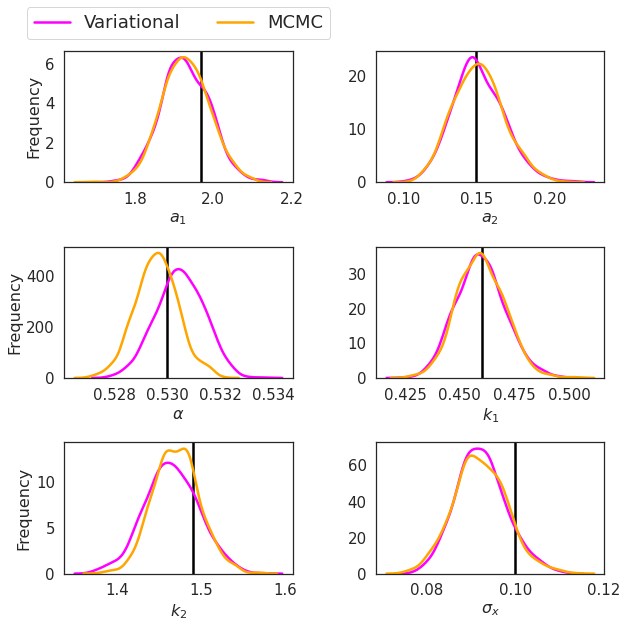

In [0]:
sns.set_context("paper", font_scale=1)
sns.set(rc={"figure.figsize":(9,9),"font.size":16,"axes.titlesize":16,"axes.labelsize":16,
           "xtick.labelsize":15, "ytick.labelsize":15},style="white")
real_params.append(0.1)
for i, p in enumerate(param_names):
        
        # Add histogram subplot
        plt.subplot(3, 2, i+1)
        plt.axvline(real_params[i], linewidth=2.5, color='black')
        if i==0:
            sns.kdeplot(vb_params_st[:, i], color='magenta', linewidth = 2.5, label='Variational')
            sns.kdeplot(mc_params_st[:, i], color='orange', linewidth = 2.5,label='MCMC')
        else:
            sns.kdeplot(vb_params_st[:, i], linewidth = 2.5, color='magenta')
            sns.kdeplot(mc_params_st[:, i], linewidth = 2.5, color='orange')  

        if i%2==0:
            plt.ylabel('Frequency')
        plt.xlabel(param_names[i])        
        if i<1:
            plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower center', ncol=2,fontsize=18)
plt.subplots_adjust(hspace=0.7)
plt.tight_layout()